In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.tree import export_graphviz
import pydot

In [42]:
DATASET = 'SEASON'
# DATASET = 'TEAM'

if DATASET == 'TEAM':
    train = pd.read_csv('../data/train_team.csv')
    test = pd.read_csv('../data/test_team.csv')

if DATASET == 'TEAM':
    train = pd.read_csv('../data/train_season.csv')
    test = pd.read_csv('../data/test_season.csv')

In [43]:
def compute_metrics(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    return [accuracy,f1_score_1,f1_score_0,f1_score_macro]

results = pd.DataFrame(columns=['Accuracy', 'F1-score (class 1)', 'F1-score (class 0)', 'F1-score (macro avg)'])

# Random Forrest on regualr season vs playoff

In [44]:
train = pd.read_csv('../data/train_season.csv')
test = pd.read_csv('../data/test_season.csv')
target_column = "shot_made_flag"  # y_column_name

In [45]:
def split_x_y(df, target):
    y = df.loc[:, [target]]
    x = df.drop([target], axis=1)
    return x, y

In [46]:
x_train, y_train = split_x_y(train, target_column)
x_test, y_test = split_x_y(test, target_column)

We are using out of the bag score (oob_score) as a way to validate our model.
Instead of using validation set and introducing data leakage, with the oob_score we are estimating the validation score.
# VERIFY

In [47]:
model_rf1 = RandomForestClassifier(oob_score=True).fit(x_train, y_train)

/tmp/ipykernel_57145/4285322127.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf1 = RandomForestClassifier(oob_score=True).fit(x_train, y_train)


In [48]:
pred = model_rf1.predict(x_train)

Performing a sanity check

In [49]:
confusion_matrix(y_train,pred)

array([[734,   0],
       [  0, 610]])

In [50]:
print('OOB accuracy=', model_rf1.oob_score_)

OOB accuracy= 0.6733630952380952


In [51]:
y_pred = model_rf1.predict(x_test)

In [52]:
confusion_matrix(y_test,y_pred)

array([[207,  27],
       [104,  90]])

In [53]:
results.loc['RF-basic', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-basic,0.693925,0.578778,0.759633,0.669206


# are the reults ok? not overfitted?

# try balanced

In [54]:
model_rf2 = RandomForestClassifier(n_estimators=100,
                                   oob_score=True,
                                   class_weight='balanced').fit(x_train, y_train)

/tmp/ipykernel_57145/215878088.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf2 = RandomForestClassifier(n_estimators=100,


In [55]:
print('OOB accuracy=', model_rf2.oob_score_)

OOB accuracy= 0.6808035714285714


In [56]:
y_pred = model_rf2.predict(x_test)

In [57]:
results.loc['RF-balanced', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-basic,0.693925,0.578778,0.759633,0.669206
RF-balanced,0.686916,0.567742,0.754579,0.66116


# Check the tree that we generated

In [58]:
x_train

,period,playoffs,shot_distance,shot_zone_basic,shot_zone_range,time_remaining,last_5_games_avg,streak_before_shot,points_before_shot,fgp_before_shot,...,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),matchup_away,matchup_home
0,1,0,0,0,0,660,0.00,0,0,0.00,...,1,0,0,1,0,0,0,0,0,1
1,4,0,0,0,0,113,0.00,0,16,0.42,...,1,0,0,1,0,0,0,0,0,1
2,4,0,14,2,1,216,0.00,0,16,0.44,...,1,0,0,0,0,0,0,1,0,1
3,4,0,28,4,3,339,0.00,0,16,0.47,...,0,1,0,1,0,0,0,0,0,1
4,4,0,8,1,1,596,0.00,0,16,0.50,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,1,0,0,0,0,386,0.43,0,0,0.00,...,1,0,0,1,0,0,0,0,0,1
1340,1,0,15,2,1,641,0.43,0,0,0.00,...,1,0,0,0,0,1,0,0,0,1
1341,4,0,30,4,3,49,0.43,0,12,0.31,...,0,1,0,1,0,0,0,0,0,1
1342,3,0,14,1,1,622,0.43,0,7,0.43,...,1,0,0,1,0,0,0,0,0,1


In [59]:
# Import tools needed for visualization

# Pull out one tree from the forest
def visualize_rf_tree(model):
    tree = model.estimators_[0]# Import tools needed for visualization
    tree = model.estimators_[0]# Export the image to a dot file
    export_graphviz(tree, out_file = 'tree.dot', feature_names = list(x_train.columns), rounded = True, precision = 1)# Use dot file to create a graph
    (graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
    graph.write_png('tree.png')

In [60]:
visualize_rf_tree(model_rf1)

# depth3

In [61]:
model_rf3_small = RandomForestClassifier(max_depth=3, n_estimators=10)
model_rf3_small.fit(x_train, y_train)

/tmp/ipykernel_57145/3649734110.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf3_small.fit(x_train, y_train)


RandomForestClassifier(max_depth=3, n_estimators=10)

In [62]:
y_pred = model_rf3_small.predict(x_test)

results.loc['RF-small', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-basic,0.693925,0.578778,0.759633,0.669206
RF-balanced,0.686916,0.567742,0.754579,0.66116
RF-small,0.679907,0.567823,0.745826,0.656824


# GridSearch
## What do we do with CV?

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


model = RandomForestClassifier()

ntrees = [10, 100, 200,None]
max_depth = [5, 10, 50, 100, None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=model,
                   # scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf,
                       'class_weight':balance
                   },
                   cv=None,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

trc.fit(x_train, y_train)

/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/filip/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed whe

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'max_depth': [5, 10, 50, 100, None],
                         'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 6],
                         'n_estimators': [10, 100, 200, None]},
             refit=False)

In [64]:
trc.best_params_

{'class_weight': 'balanced_subsample',
 'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 6,
 'n_estimators': 10}

In [65]:
model_rf4_gs = RandomForestClassifier(**trc.best_params_)


In [66]:
model_rf4_gs.fit(x_train, y_train)

/tmp/ipykernel_57145/2237850149.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf4_gs.fit(x_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       min_samples_leaf=4, min_samples_split=6,
                       n_estimators=10)

In [67]:
y_pred = model_rf4_gs.predict(x_test)
results.loc['RF-gridsearch', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-basic,0.693925,0.578778,0.759633,0.669206
RF-balanced,0.686916,0.567742,0.754579,0.66116
RF-small,0.679907,0.567823,0.745826,0.656824
RF-gridsearch,0.64486,0.542169,0.709924,0.626046


In [68]:
confusion_matrix(y_test, y_pred)

array([[186,  48],
       [104,  90]])

# Check feature importance

In [69]:
model_rf4_gs.feature_importances_

array([0.01574838, 0.        , 0.0543947 , 0.04108791, 0.00363443,
       0.06334202, 0.01917345, 0.02012947, 0.03763952, 0.07168503,
       0.04318833, 0.01647044, 0.3298901 , 0.11396503, 0.02130534,
       0.03237535, 0.        , 0.03075121, 0.00721807, 0.        ,
       0.00043179, 0.01855634, 0.        , 0.01680987, 0.02342605,
       0.00293337, 0.00152945, 0.00180909, 0.00507507, 0.0074302 ])

In [70]:
# Get numerical feature importances
importances = list(model_rf1.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(x_train.columns), importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: action_type_te       Importance: 0.16
Variable: time_remaining       Importance: 0.11
Variable: fgp_before_shot      Importance: 0.09
Variable: opponent_te          Importance: 0.09
Variable: points_before_shot   Importance: 0.08
Variable: shot_distance        Importance: 0.07
Variable: last_5_games_avg     Importance: 0.07
Variable: period               Importance: 0.04
Variable: streak_before_shot   Importance: 0.04
Variable: month                Importance: 0.04
Variable: weekday              Importance: 0.04
Variable: shot_zone_basic      Importance: 0.02
Variable: shot_zone_range      Importance: 0.02
Variable: combined_shot_type_Dunk Importance: 0.01
Variable: combined_shot_type_Jump Shot Importance: 0.01
Variable: combined_shot_type_Layup Importance: 0.01
Variable: shot_zone_area_Center(C) Importance: 0.01
Variable: shot_zone_area_Left Side Center(LC) Importance: 0.01
Variable: shot_zone_area_Left Side(L) Importance: 0.01
Variable: shot_zone_area_Right Side Center(RC) 

If we change the model, we would still get action_type_te as most important

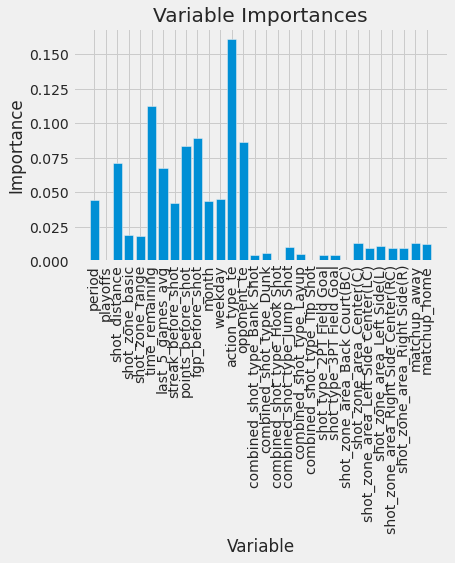

In [71]:
# Set the style
plt.style.use('fivethirtyeight')# list of x locations for plotting
x_values = list(range(len(importances)))# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')# Tick labels for x axis
plt.xticks(x_values, list(x_train.columns), rotation='vertical')# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Run with reduced features

In [72]:
top_features = [tuple[0] for tuple in feature_importances[:5]]

In [73]:
top_features

['action_type_te',
 'time_remaining',
 'fgp_before_shot',
 'opponent_te',
 'points_before_shot']

In [74]:
x_train_top = x_train.loc[:, top_features]
x_test_top = x_test.loc[:, top_features]

In [75]:
x_test_top

,action_type_te,time_remaining,fgp_before_shot,opponent_te,points_before_shot
0,0.736842,443,0.00,0.387755,0
1,0.342105,194,0.31,0.387755,11
2,0.777778,242,0.27,0.387755,9
3,0.000000,277,0.29,0.387755,9
4,0.342105,391,0.25,0.387755,6
...,...,...,...,...,...
423,0.392857,488,0.00,0.416667,0
424,0.342105,498,0.00,0.416667,0
425,0.342105,237,0.31,0.416667,10
426,1.000000,154,0.14,0.416667,2


In [76]:
model_rf5_top = RandomForestClassifier(**trc.best_params_)

In [77]:
model_rf5_top.fit(x_train_top, y_train)

/tmp/ipykernel_57145/4164285385.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf5_top.fit(x_train_top, y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       min_samples_leaf=4, min_samples_split=6,
                       n_estimators=10)

In [78]:
y_pred = model_rf5_top.predict(x_test_top)

In [79]:
y_pred = model_rf4_gs.predict(x_test)
results.loc['RF-gridsearch-top', :] = compute_metrics(y_test, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-basic,0.693925,0.578778,0.759633,0.669206
RF-balanced,0.686916,0.567742,0.754579,0.66116
RF-small,0.679907,0.567823,0.745826,0.656824
RF-gridsearch,0.64486,0.542169,0.709924,0.626046
RF-gridsearch-top,0.64486,0.542169,0.709924,0.626046
